In [1]:
import sys
sys.path.append('../')
from torchdyn.models import *
from torchdyn import *
from torchdyn.datasets import *

# Higher-Order Neural ODEs

Following [Dissecting Neural ODEs](www.aaaa.com), In this tutorial we showcase how to handle **higher-order neural ODEs** in `torchdyn`

**Data:** we use again the moons dataset (with some added noise) simply because all the models will be effective to solve the binary classification problem.



In [2]:
d = ToyDataset()
X, yn = d.generate(n_samples=2048, dataset_type='moons', noise=.4)

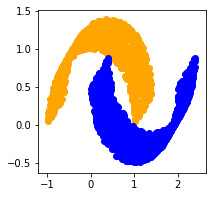

In [3]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], color=colors[yn[i].int()])

In [4]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

**Learner**

In [5]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module): #settings:dict={}):
        super().__init__()
        #defaults.update(settings)
        #self.settings = defaults
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)  
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.005)

    def train_dataloader(self):
        return trainloader

In [6]:
from torch.autograd import grad as grad

In [7]:
import pdb
class intloss(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
    def forward(self):
        #x.requires_grad_(True)
        loss = 1e-4*torch.abs(self.f(x)).sum(1) #grad(self.f(s, x), x, create_graph=True
        return loss

In [8]:
# vector field parametrized by a NN
f = nn.Sequential(
        nn.Linear(6, 1024),
        nn.Tanh(), 
        nn.Linear(64, 2))

# neural ODE
model = NeuralDE(f, 
                 order=3,
                 solver='dopri5', 
                 sensitivity='adjoint', 
                 intloss=None).to(device)
seq = nn.Sequential(Augmenter(1, 4, order='last'), model)

In [9]:
torch.rand(10).requires_grad_(True).shape

torch.Size([10])

In [10]:
# train the neural ODE
learn = Learner(seq)
trainer = pl.Trainer(min_epochs=300, max_epochs=600)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 578   


1

**Plots**

In [11]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
X_d = seq[0](X_train)
trajectory = model.trajectory(X_d, s_span).detach().cpu()

IndexError: index 0 is out of bounds for dimension 2 with size 0

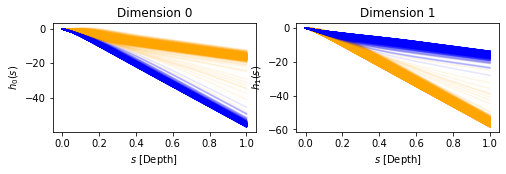

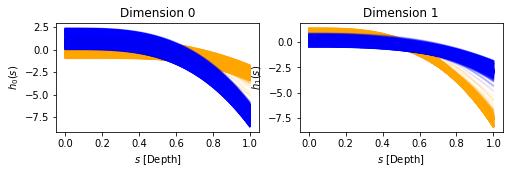

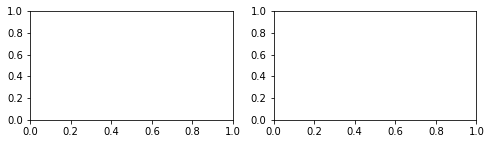

In [12]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory[:,:,-2:], yn, len(X))
plot_2D_depth_trajectory(s_span, trajectory[:,:,:2], yn, len(X))
plot_2D_depth_trajectory(s_span, trajectory[:,:,2:2], yn, len(X))

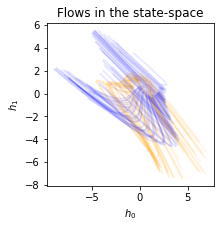

In [38]:
# Trajectories in the state-space
plot_2D_state_space(trajectory[:,:,-2:], yn, len(X),)

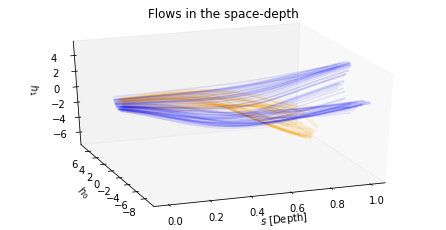

In [39]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory[:,:,-2:], yn, len(X))